### Load data first

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import time
import sys

sys.path.append(os.path.abspath(".."))   # Add root path to sys.path
os.chdir("..")  # Change working directory to root path

from tqdm import tqdm
from datetime import datetime

### Setup Parameters

In [40]:
DATASET = "KGRR"

MAX_RADIUS = 120
NUM_RADII = 10
NUM_SECTORS = 8
DENSITY = 0.05

MAX_VELOCITY = 500
SHAPE_DIFF_WEIGHT = 0.5         # weights of the shape vector difference in the cost function, this will sum with spatial distance weight to 1.0

RADII = np.linspace(start=MAX_RADIUS/NUM_RADII, stop=MAX_RADIUS, num=NUM_RADII, dtype=int).tolist()

In [41]:
from src.preprocessing import read_numpy_grid, nexrad_numpy_preprocessing_pipeline

SOURCE_PATH = f"data/numpy_grid/{DATASET}"
img_paths = [os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.npy')]

dbz_maps: list[tuple[np.ndarray, datetime]] = []

for path in tqdm(img_paths, desc="Processing images and detecting storms"):
    file_name = path.split("/")[-1].split(".")[0]

    time_frame = datetime.strptime(file_name[4:19], "%Y%m%d_%H%M%S")
    img = read_numpy_grid(path)
    dbz_maps.append((img, time_frame))

print(f"Number of frames: {len(dbz_maps)} | Shape of each frame: {dbz_maps[0][0].shape}")

Processing images and detecting storms: 100%|██████████| 31/31 [00:00<00:00, 587.27it/s]

Number of frames: 31 | Shape of each frame: (901, 901)


## Load model

In [42]:
# import sys

# for k in list(sys.modules.keys()):
#     if k.startswith('src.'):
#         del sys.modules[k]
#         print(f"Deleted module: {k}")

In [43]:
from tqdm import tqdm

from src.models import OursPrecipitationModel
from src.identification import HypothesisIdentifier, MorphContourIdentifier

model = OursPrecipitationModel(identifier=MorphContourIdentifier(), radii=RADII, num_sectors=NUM_SECTORS, density=DENSITY)
storms_maps = []

for idx, (dbz_map, time_frame) in tqdm(list(enumerate(dbz_maps))):
    storms_map = model.identify_storms(dbz_map, time_frame, map_id=f"time_{idx}", threshold=35, filter_area=50)
    storms_maps.append(storms_map)

100%|██████████| 31/31 [00:43<00:00,  1.40s/it]


## Benchmark model
Assume that storm do not change overtime, use previous map as the predicted map

In [44]:
from src.cores.base import StormsMap
from src.cores.metrics import pod_score, far_score, csi_score

class PredictionBenchmarkModel:
    def __init__(self):
        self.pods = []
        self.fars = []
        self.csis = []
        self.actual = []
        self.predicted = []

    def evaluate_predict(self, actual_storms_map: StormsMap, predicted_storms_map: StormsMap):
        self.actual.append(actual_storms_map)
        self.predicted.append(predicted_storms_map)
        self.pods.append(pod_score(actual_storms_map, predicted_storms_map))
        self.fars.append(far_score(actual_storms_map, predicted_storms_map))
        self.csis.append(csi_score(actual_storms_map, predicted_storms_map))

# Create benchmark model
PREDICT_FORWARD_STEPS = 5                           # 1 hour ahead
SLOW_START_STEPS = 5

model = OursPrecipitationModel(identifier=HypothesisIdentifier(), max_velocity=MAX_VELOCITY, weights=(1-SHAPE_DIFF_WEIGHT, SHAPE_DIFF_WEIGHT))  # max_velocity in pixels per hour
# model = TitanPrecipitationModel(identifier=SimpleContourIdentifier())
temp_storm_map = storms_maps

ours_model_evaluation = PredictionBenchmarkModel()
predicted_maps = []

for i in range(SLOW_START_STEPS):
    model.processing_map(temp_storm_map[i])  # Warm-up phase

for curr_map, future_map in tqdm(list(zip(temp_storm_map[SLOW_START_STEPS:], temp_storm_map[PREDICT_FORWARD_STEPS + SLOW_START_STEPS:])), desc="Predicting precipitation maps"):
    # Predict map using current data
    dt_seconds = (future_map.time_frame - model.storms_maps[-1].time_frame).total_seconds()
    predicted_map = model.forecast(dt_seconds)
    ours_model_evaluation.evaluate_predict(future_map, predicted_map)

    # Update new map into knowledge
    model.processing_map(curr_map)  # Update model with the current map

print("Our model evaluation:")
print(f"\tAverage POD: {np.mean(ours_model_evaluation.pods):.4f}")
print(f"\tAverage FAR: {np.mean(ours_model_evaluation.fars):.4f}")
print(f"\tAverage CSI: {np.mean(ours_model_evaluation.csis):.4f}")

Predicting precipitation maps: 100%|██████████| 21/21 [00:00<00:00, 28.09it/s]

Our model evaluation:
	Average POD: 0.2398
	Average FAR: 0.7043
	Average CSI: 0.1535


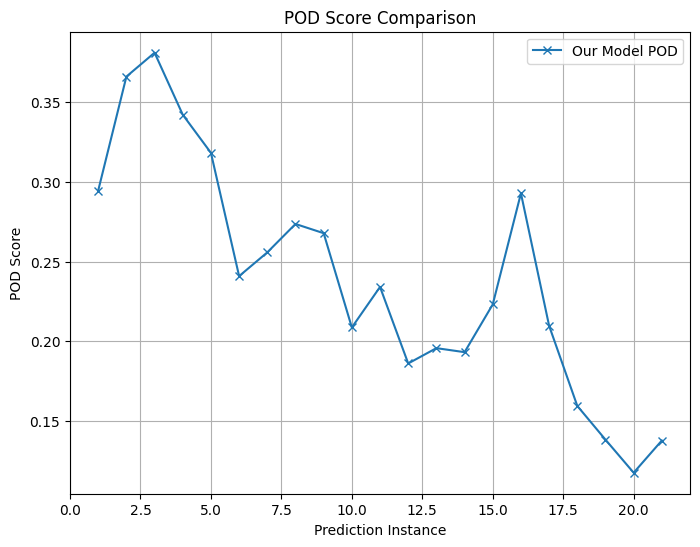

In [45]:
# Plotting POD curve

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(ours_model_evaluation.pods) + 1), ours_model_evaluation.pods, label='Our Model POD', marker='x')
plt.xlabel('Prediction Instance')
plt.ylabel('POD Score')
plt.title('POD Score Comparison')
plt.legend()
plt.grid()
plt.show()

# Overall Analyzing on tracking process
In this tracking, I used both of the median duration and linearity error of tracking

## A. Object consistency

Average object consistency score (area change rate): 0.1987


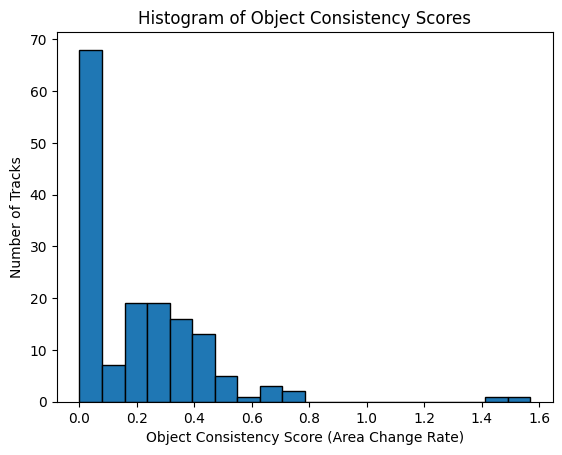

In [46]:
object_consistency_scores = []

for track in model.tracker.tracks:
    areas = [storm.contour.area for storm in track.storms.values()]
    area_changes = [abs(areas[i] - areas[i - 1]) / areas[i - 1] for i in range(1, len(areas)) if areas[i - 1] != 0]
    object_consistency_scores.append(np.mean(area_changes) if area_changes else 0)

object_consistency_scores = np.array(object_consistency_scores)

print(f"Average object consistency score (area change rate): {np.mean(object_consistency_scores):.4f}")

plt.hist(object_consistency_scores[object_consistency_scores < 2], bins=20, edgecolor='black')
plt.title("Histogram of Object Consistency Scores")
plt.xlabel("Object Consistency Score (Area Change Rate)")
plt.ylabel("Number of Tracks")
plt.show()

## B. Mean duration tracking

Median duration of tracking: 4.567741935483871 frames
Maximum duration of tracking: 26 frames
Mean duration of tracking: 4.57 frames


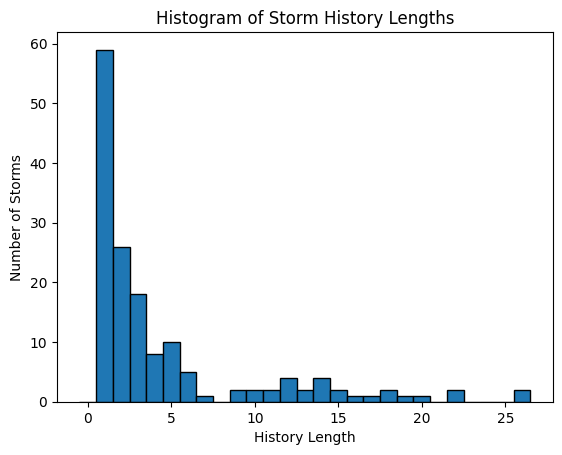

In [47]:
HISTORY_LENGTH_LST = []             # Retrieve history length of all storms

# for storms_map in storms_maps:
#     for storm in storms_map.storms:
#         HISTORY_LENGTH_LST.append(len(storm.history_movements))   # Append history length of each storm
for track in model.tracker.tracks:
    HISTORY_LENGTH_LST.append(len(track.storms))   # Append history length of each storm track

MEDIAN_DURATION = np.mean(HISTORY_LENGTH_LST)
history_lengths = np.array(HISTORY_LENGTH_LST)

print(f"Median duration of tracking: {MEDIAN_DURATION} frames")
print(f"Maximum duration of tracking: {max(HISTORY_LENGTH_LST)} frames")
print(f"Mean duration of tracking: {np.mean(HISTORY_LENGTH_LST):.2f} frames")

plt.hist(HISTORY_LENGTH_LST, bins=range(0, max(HISTORY_LENGTH_LST) + 2), align='left', edgecolor='black')
plt.title("Histogram of Storm History Lengths")
plt.xlabel("History Length")
plt.ylabel("Number of Storms")
plt.show()

## C. Linearity error tracking
Use linearity to track the different between linear fitting of previous history against the actual matched movement

In [48]:
from src.cores.metrics import linear_tracking_error
import matplotlib.pyplot as plt

# Accumulate linear errors for all storms
LINEAR_ERRORS_LST = []

for storms_map in tqdm(storms_maps, desc="Computing linear fitting errors for storms"):
    for storm in storms_map.storms:
        # If not enough history, skip
        if len(storm.history_movements) < MEDIAN_DURATION:
            continue

        # Fit linear model
        error_distance = linear_tracking_error(storm.history_movements[:-1]) ** 2      # Final one used for evaluate the movement prediction
        LINEAR_ERRORS_LST.append(error_distance)

print(f"RMSE of linear fitting errors: {np.sqrt(np.mean(LINEAR_ERRORS_LST)):.4f}. Total length: {len(LINEAR_ERRORS_LST)}")

Computing linear fitting errors for storms: 100%|██████████| 31/31 [00:00<00:00, 490.76it/s]

RMSE of linear fitting errors: 127.1610. Total length: 496


Processing all storm maps for movement history visualization: 100%|██████████| 31/31 [00:00<00:00, 70.10it/s]


----  CURRENT MAP at time 2024-05-08 00:57:09  ----
Storm 0: Number of movement history records: 30
Storm 1: Number of movement history records: 30
Storm 2: Number of movement history records: 10
Storm 3: Number of movement history records: 17
Storm 4: Number of movement history records: 30
Storm 5: Number of movement history records: 5
Storm 6: Number of movement history records: 30
Storm 7: Number of movement history records: 26
Storm 8: Number of movement history records: 30
Storm 9: Number of movement history records: 26
Storm 10: Number of movement history records: 2
Storm 11: Number of movement history records: 5
Storm 12: Number of movement history records: 3
Storm 13: Number of movement history records: 7
Storm 14: Number of movement history records: 19
Storm 15: Number of movement history records: 8
Storm 16: Number of movement history records: 0
Storm 17: Number of movement history records: 1


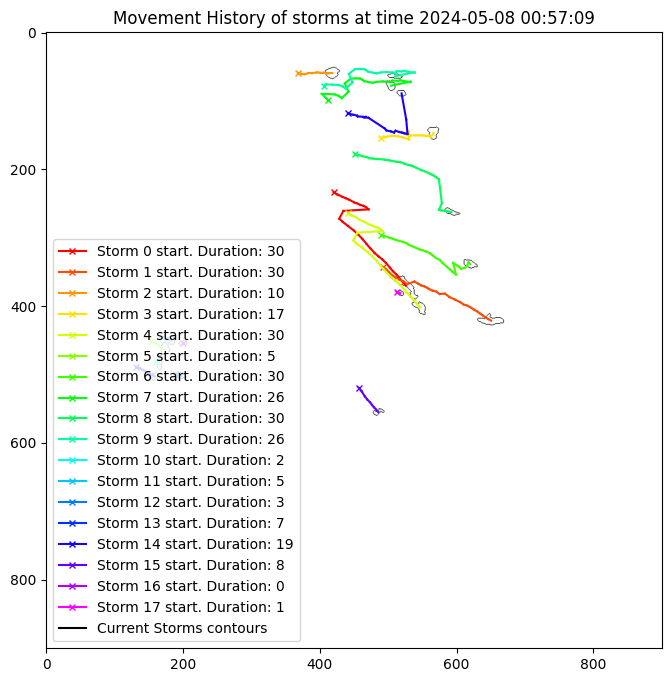

In [49]:
from src.preprocessing import convert_polygons_to_contours

num_maps = len(storms_maps)
MAX_VELOCITY = 500              # pixels per hour

model = OursPrecipitationModel(identifier=HypothesisIdentifier(), max_velocity=MAX_VELOCITY)  # max_velocity in pixels per hour

for i in tqdm(range(num_maps), desc="Processing all storm maps for movement history visualization"):
    model.processing_map(storms_maps[i])  # Warm-up phase

plt.figure(figsize=(8, 8))
img_shape = dbz_maps[0][0].shape
blank_img = np.ones(shape=(img_shape[0], img_shape[1], 3), dtype=np.uint8) * 255

current_map = storms_maps[-1]
print(f"----  CURRENT MAP at time {current_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')}  ----")

import colorsys

def spectral_colors(n: int) -> list[list[int]]:
    colors = []
    for i in range(n):
        # Hue ranges from 0.0 (red) to 0.83 (violet) approximately
        hue = i / max(1, n - 1) * 0.83  
        r, g, b = colorsys.hsv_to_rgb(hue, 1.0, 1.0)
        colors.append([int(r * 255), int(g * 255), int(b * 255)])
    return colors
colors = spectral_colors(len(current_map.storms))

for idx, storm in enumerate(current_map.storms):
    print(f"Storm {idx}: Number of movement history records: {len(storm.history_movements)}")
    current_frame = current_map.time_frame

    color = np.array(colors[idx]) / 255.0
    end_point = (storm.contour.centroid.x, storm.contour.centroid.y)

    # backtrack the movement history
    for move_idx, movement in enumerate(storm.history_movements):
        prev_frame = storms_maps[-(move_idx + 2)].time_frame
        dt = (current_frame - prev_frame).seconds / 3600
        current_frame = prev_frame

        dy, dx = movement[0] * dt, movement[1] * dt

        start = end_point[0] - dx, end_point[1] - dy
        plt.plot([start[0], end_point[0]], [start[1], end_point[1]], color=color)
        end_point = start
    
    plt.plot(end_point[0], end_point[1], marker='x', color=color, markersize=5, label=f'Storm {idx} start. Duration: {len(storm.history_movements)}')

contours = convert_polygons_to_contours([storm.contour for storm in current_map.storms])
cv2.drawContours(blank_img, contours, -1, (0, 0, 0), 1)
plt.plot([], [], color='black', label='Current Storms contours')
plt.title(f"Movement History of storms at time {current_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')}")

plt.imshow(blank_img)
plt.legend()

plt.show()

## D. Post-event analysis

### Plot histogram of track length

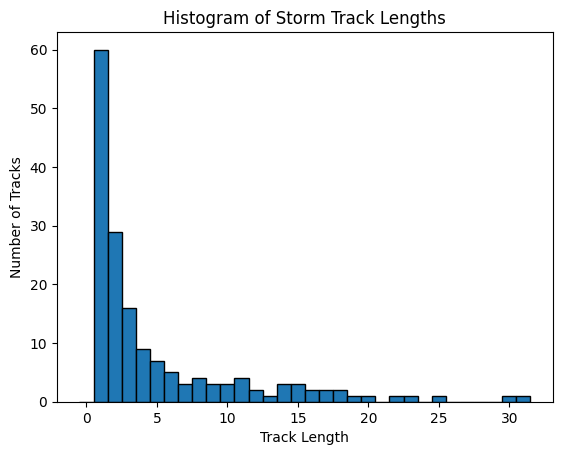

In [50]:
# Get the centroids list
centroids = []
clusters_assigned = []

FIRST_TIME_FRAME = dbz_maps[0][1]

def _convert_time_frame_to_seconds(time_frame: datetime) -> float:
    return time_frame.timestamp() - FIRST_TIME_FRAME.timestamp()

for track_history in model.tracker.tracks:
    track_centroids = [(storm.centroid[0], storm.centroid[1], _convert_time_frame_to_seconds(time_frame)) for time_frame, storm in track_history.storms.items()]
    centroids.extend(track_centroids)
    clusters_assigned.extend([track_history.id] * len(track_centroids))

centroids = np.array(centroids)

track_lengths = [len(track_history.storms) for track_history in model.tracker.tracks]

plt.hist(track_lengths, bins=range(0, max(track_lengths) + 2), align='left', edgecolor='black')
plt.title("Histogram of Storm Track Lengths")
plt.xlabel("Track Length")
plt.ylabel("Number of Tracks")
plt.show()

In [51]:
from typing import Annotated
from src.cores.metrics.postevent_tracking import PostEventClustering
    
postevent_analysis = PostEventClustering(centroids, max_window_time=600, spatial_distance_threshold=50)
reassigned_clusters_centers = postevent_analysis.fit_transform(num_clusters=len(model.tracker.tracks), clusters_assigned=clusters_assigned, max_epochs=50)

active_lst = [i for i, cluster in enumerate(postevent_analysis.clusters) if cluster.is_actived]
print(f"Total {len(active_lst)} / {postevent_analysis.num_initial_clusters} Clusters active: {active_lst}")
print(f"Number of active storm tracks after post-event clustering: {len([c for c in reassigned_clusters_centers if c != -1])} / {len(reassigned_clusters_centers)}")

# Scoring: 1 if match best clusters, 0.5 if match wrong clusters and 0 if storm is dropped
merged_clusters_assigned = [postevent_analysis.clusters_merged_dict.get(i, i) for i in clusters_assigned]
score_lst = [1 if merged_clusters_assigned[i] == reassigned_clusters_centers[i] else 0.5 if reassigned_clusters_centers[i] != -1 else 0 for i in range(len(clusters_assigned))]
print(f"Post-event clustering scoring results: {sum(score_lst) / len(score_lst):.4f}")

Post-event clustering:   0%|          | 0/50 [00:00<?, ?it/s]

Total 82 / 165 Clusters active: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 13, 14, 15, 18, 19, 24, 25, 27, 28, 29, 30, 32, 36, 39, 40, 42, 46, 47, 49, 50, 51, 52, 53, 61, 64, 65, 67, 68, 71, 72, 73, 75, 76, 80, 81, 86, 87, 94, 96, 97, 100, 102, 107, 111, 115, 116, 119, 120, 127, 128, 129, 131, 133, 134, 136, 137, 138, 142, 143, 145, 147, 148, 149, 151, 152, 153, 154, 155, 157, 158, 159, 160]
Number of active storm tracks after post-event clustering: 797 / 817
Post-event clustering scoring results: 0.8060


### Scoring using Post-event analysis

In [52]:
# import pandas as pd
# import numpy as np
# import os

# SAVED_PATH = "output/tracking/tracking_evaluation_results.csv"

# if os.path.exists(SAVED_PATH):
#     df = pd.read_csv(SAVED_PATH)
# else:
#     df = pd.DataFrame(columns=["Dataset", "Model", "object_consistency", "mean_duration", "linear_rmse", "postevent_score"])

# new_row = {
#     "Dataset": DATASET,
#     "Model": "Ours",
#     "object_consistency": np.mean(object_consistency_scores),
#     "mean_duration": np.mean(history_lengths),
#     "linear_rmse": np.sqrt(np.mean(LINEAR_ERRORS_LST)),
#     "postevent_score": sum(score_lst) / len(score_lst)
# }

# # Check if the entry already exists
# existing_entry = df[(df["Dataset"] == DATASET) & (df["Model"] == "Ours")]
# if not existing_entry.empty:
#     df.update(pd.DataFrame([new_row], index=existing_entry.index))
# else:
#     df.loc[len(df)] = new_row

# df.sort_values(by=["Dataset", "Model"], inplace=True)
# df.reset_index(drop=True, inplace=True)

# df.to_csv(SAVED_PATH, index=False)
# df